In [16]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.linalg import eigh
import qutip as qt
import sympy as sym
from joblib import Parallel, delayed, cpu_count

%matplotlib ipympl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

# Comparison of sqcircuit composite vs full circuit model

In [17]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0 = h/(2*e0)

In [18]:
C, CJ, Csh, Lq, Lr, Δ, EJ = (
    sq_ext.get_experimental_parameters('qubit_1', return_effective=False))
CR, CF, LF, LR, EJ, Δ, ω_r = (
    sq_ext.get_experimental_parameters('qubit_1', return_effective=True))
C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=False))
CR_prime, CF_prime, LF_prime, LR_prime, EJ_prime, Δ_prime, ω_r_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=True))

LC = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)[2]
LC_prime = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq_prime , Lr_prime , Δ_prime )[2]

In [22]:
nmax_r = 5
nmax_f = 10
CC = 10
only_inner = False
compensate_extra_cap = False
only_renormalization = False
n_eig = 6
φ_ext = 0.5
φ_ext_prime = 0.5

In [23]:
experiment_colors = ['b', 'g', 'r']
experiment_labels = ['Unit cell 1', 'Coupler', 'Unit cell 2']
colors = figs.generate_colors_from_colormap(n_eig, 'tab10')

In [24]:
circ_full = sq_ext.sq_qubit_C_qubit(CC=CC, C=C, CJ=CJ, Csh=Csh, Lq=Lq, Lr=Lr, Δ=Δ, EJ=EJ, φ_ext=φ_ext,
                                      C_prime=C_prime, CJ_prime=CJ_prime, Csh_prime=Csh_prime, Lq_prime=Lq_prime, Lr_prime=Lr_prime, Δ_prime=Δ_prime, EJ_prime=EJ_prime, φ_ext_prime=φ_ext,
                                      nmax_r=nmax_r, nmax_f=nmax_f, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap, only_renormalization=only_renormalization)
circ_full.diag(n_eig)
E_full = circ_full.efreqs
E_full  = E_full-E_full[0]

In [25]:
C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization) 
C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)

In [26]:
CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1
fluxonium       = sq_ext.sq_fluxonium(C_F_eff=CF_tilde,       L_F_eff=LF,       Δ=Δ,       EJ=EJ,       nmax_f=nmax_f, φ_ext=φ_ext)
resonator       = sq_ext.sq_resonator(C_R_eff=CR_tilde,       L_R_eff=LR,       Δ=Δ,       EJ=EJ,       nmax_r=nmax_r)
fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)
resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)
circuits = [fluxonium, resonator, fluxonium_prime,resonator_prime]
LCs = [LC, LC_prime]

In [27]:
H_qubit_C_qubit = sq_ext.hamiltonian_qubit_C_qubit(C_inv_qubit_C_qubit, circuits, LCs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=False)
E_qubit_C_qubit= sq_ext.diag(H_qubit_C_qubit, n_eig,   remove_ground=True)[0]

In [28]:
H_fluxonium_C_fluxonium = sq_ext.hamiltonian_fluxonium_C_fluxonium(C_inv_qubit_C_qubit[[0,2],:][:,[0,2]], [circuits[0],circuits[2]], nmax_f=nmax_f, return_H_0=False)
E_fluxonium_C_fluxonium= sq_ext.diag(H_fluxonium_C_fluxonium, n_eig,   remove_ground=True)[0]

In [29]:
E_full, E_qubit_C_qubit, E_fluxonium_C_fluxonium

(array([0.000000000000, 2.888547333715, 3.523180921901, 4.076157389551, 6.265898685099, 6.380260243029]),
 array([0.000000000000, 2.880548835052, 3.519828888401, 4.076019364312, 6.156806646004, 6.380187392891]),
 array([0.000000000000, 2.882446317203, 3.535448470449, 6.166260212193, 7.497998912845, 7.764864258698]))

## Spectrum vs parameter functions for the different models

In [30]:
def comp_spectrum_Q_c_Q(CC, CR, CF, LF, LR, LC, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, LC_prime, EJ_prime, Δ_prime, φ_ext_prime, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization, n_eig=5):
    
    C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization) 
    C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
    
    CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
    CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
    CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
    CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1
    
    fluxonium       = sq_ext.sq_fluxonium(C_F_eff=CF_tilde,       L_F_eff=LF,       Δ=Δ,       EJ=EJ,       nmax_f=nmax_f, φ_ext=φ_ext)
    resonator       = sq_ext.sq_resonator(C_R_eff=CR_tilde,       L_R_eff=LR,       Δ=Δ,       EJ=EJ,       nmax_r=nmax_r)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)
    resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)
    circuits = [fluxonium, resonator, fluxonium_prime,resonator_prime]
    LCs = [LC, LC_prime]
    
    H_qubit_C_qubit = sq_ext.hamiltonian_qubit_C_qubit(C_inv_qubit_C_qubit, circuits, LCs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=False)
    
    return sq_ext.diag(H_qubit_C_qubit, n_eig,   remove_ground=True)[0] 


In [31]:
def qubit_spectrum_Q_c_Q(CC, CR, CF, LF, LR, LC, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, LC_prime, EJ_prime, Δ_prime, φ_ext_prime, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization, n_eig=5):
    
    C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization) 
    C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
    
    CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
    CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
    
    fluxonium       = sq_ext.sq_fluxonium(C_F_eff=CF_tilde,       L_F_eff=LF,       Δ=Δ,       EJ=EJ,       nmax_f=nmax_f, φ_ext=φ_ext)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)
    circuits = [fluxonium, _, fluxonium_prime,_]
    
    H_fluxonium_C_fluxonium = sq_ext.hamiltonian_fluxonium_C_fluxonium(C_inv_qubit_C_qubit[[0,2],:][:,[0,2]], [circuits[0],circuits[2]], nmax_f=10, return_H_0=False)
    
    return sq_ext.diag(H_fluxonium_C_fluxonium, n_eig,   remove_ground=True)[0]


In [32]:
def full_spectrum_Q_c_Q(CC, C, CJ, Csh, Lq, Lr, Δ, EJ, φ_ext, C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime, φ_ext_prime, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization, n_eig=5):
    circ_full = sq_ext.sq_qubit_C_qubit(CC=CC, C=C, CJ=CJ, Csh=Csh, Lq=Lq, Lr=Lr, Δ=Δ, EJ=EJ, φ_ext=φ_ext,
                                          C_prime=C_prime, CJ_prime=CJ_prime, Csh_prime=Csh_prime, Lq_prime=Lq_prime, Lr_prime=Lr_prime, Δ_prime=Δ_prime, EJ_prime=EJ_prime, φ_ext_prime=φ_ext_prime,
                                          nmax_r=nmax_r, nmax_f=nmax_f, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap,only_renormalization=only_renormalization)
    circ_full.diag(n_eig)
    E = circ_full.efreqs
    return E-E[0]

## Spectrum vs $\Phi_{ext}$

In [54]:
nmax_r = 5
nmax_f = 10
CC = 1
only_inner = True
compensate_extra_cap = False
only_renormalization = False 
n_eig=4

φ_ext_values = np.linspace(0.5, 1, 30)
# φ_ext_values_full = np.array([0.5, 0.522, 0.55, 0.58, 0.625, 0.67, 0.75])
φ_ext_values_full = np.array([0.5, 0.522, 0.58, 0.67, 0.75, 1])

In [55]:
E_composite = np.array(Parallel(n_jobs=10)( delayed(comp_spectrum_Q_c_Q)(CC, CR, CF, LF, LR, LC, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, LC_prime, EJ_prime, Δ_prime, φ_ext, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization, n_eig) for φ_ext in φ_ext_values))

In [56]:
E_qubits  = np.array(Parallel(n_jobs=10)( delayed(qubit_spectrum_Q_c_Q)(CC, CR, CF, LF, LR, LC, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, LC_prime, EJ_prime, Δ_prime, φ_ext, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization,n_eig) for φ_ext in φ_ext_values))

In [57]:
E_full  = np.array(Parallel(n_jobs=len(φ_ext_values_full))( delayed(full_spectrum_Q_c_Q)(CC, C, CJ, Csh, Lq, Lr, Δ, EJ, φ_ext, C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime, φ_ext, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization,n_eig) for φ_ext in φ_ext_values_full))

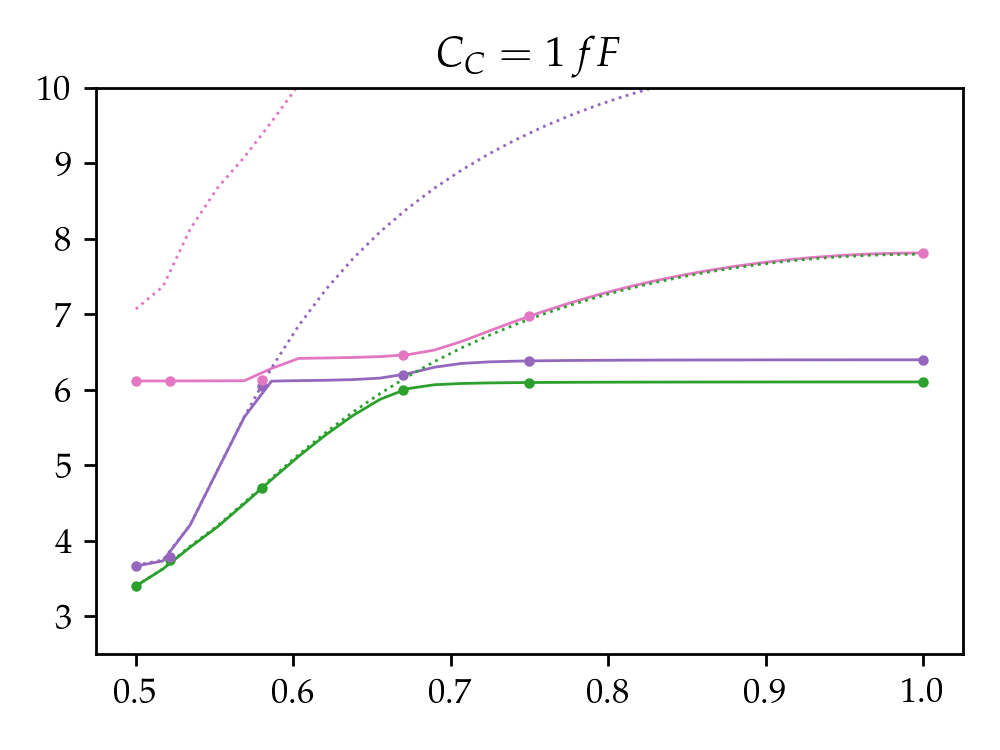

In [58]:
fig, ax = plt.subplots(figsize=[4,3], dpi=250)
[ax.plot(φ_ext_values, E_composite[:,i], linewidth=0.8, color=colors[i]) for i in range(n_eig)]
[ax.plot(φ_ext_values, E_qubits[:,i], ':', linewidth=0.8, color=colors[i]) for i in range(n_eig)]
[ax.plot(φ_ext_values_full, E_full[:,i],'o', color=colors[i], markersize=2) for i in range(n_eig)]
ax.set_ylim([2.5, 10])
ax.set_title(f'$C_C={CC}\\,fF$')
fig.tight_layout()
fig.show()

## Spectrum vs $C_C$

In [73]:
nmax_r = 5
nmax_f = 10
CC_values      = np.geomspace(1e-4,1e2, 50)
CC_values_full = np.geomspace(1e-4,1e2, 5)
only_inner = True
compensate_extra_cap = False
only_renormalization = False 
φ_ext=0.5
n_eig = 7
n_eig_qubit = 5


In [74]:
E_composite = np.array(Parallel(n_jobs=10)( delayed(comp_spectrum_Q_c_Q)(CC, CR, CF, LF, LR, LC, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, LC_prime, EJ_prime, Δ_prime, φ_ext, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization, n_eig) for CC in CC_values))

In [75]:
E_qubits  = np.array(Parallel(n_jobs=10)( delayed(qubit_spectrum_Q_c_Q)(CC, CR, CF, LF, LR, LC, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, LC_prime, EJ_prime, Δ_prime, φ_ext, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization, n_eig_qubit) for CC in CC_values))

In [62]:
E_full  = np.array(Parallel(n_jobs=len(CC_values_full))( delayed(full_spectrum_Q_c_Q)(CC, C, CJ, Csh, Lq, Lr, Δ, EJ, φ_ext, C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime, φ_ext, nmax_r, nmax_f, only_inner, compensate_extra_cap,only_renormalization, n_eig) for CC in CC_values_full))

In [94]:
C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(0, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization) 
C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)

CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
fluxonium       = sq_ext.sq_fluxonium(C_F_eff=CF_tilde,       L_F_eff=LF,       Δ=Δ,       EJ=EJ,       nmax_f=nmax_f, φ_ext=φ_ext)
fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)

In [95]:
fluxonium.diag(4)
fluxonium.efreqs-fluxonium.efreqs[0]

array([0.000000000000, 3.688698541418, 8.094706043815, 12.925424412943])

In [96]:
fluxonium_prime.diag(4)
fluxonium_prime.efreqs-fluxonium_prime.efreqs[0]

array([0.000000000000, 3.423349311519, 8.518987163636, 14.280471075769])

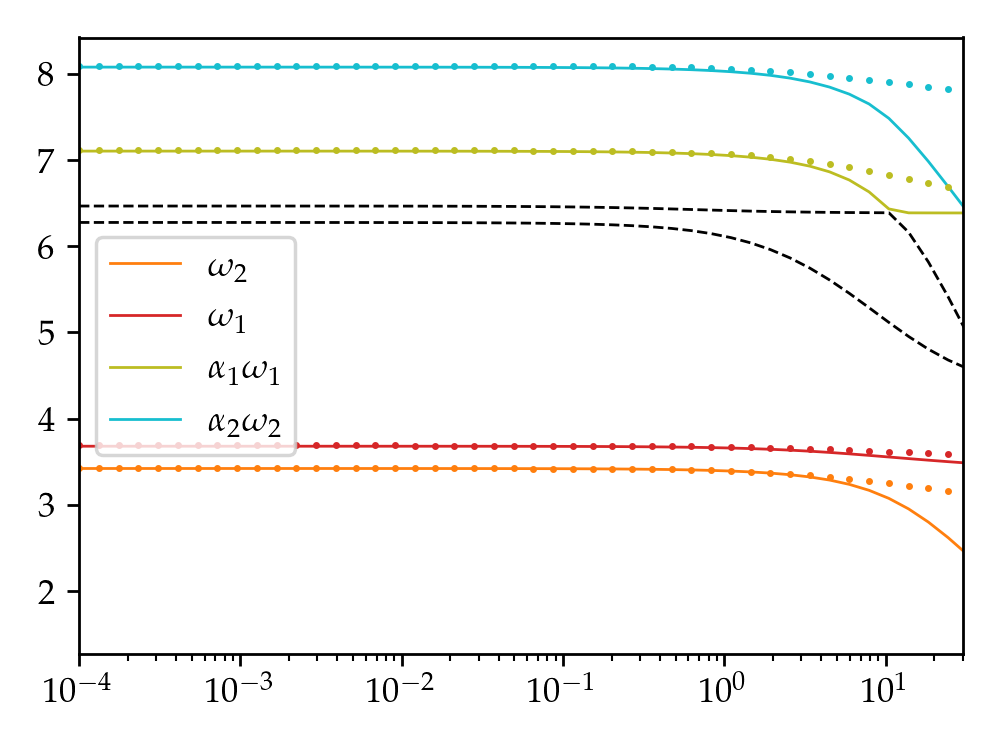

In [118]:
colors = figs.generate_colors_from_colormap(n_eig, 'tab10')

qubit_indices = [1,2,5,6]
resonator_indices = [3,4]

colors_qubit = [colors[i] for i in qubit_indices]
colors_resonator = [colors[i] for i in resonator_indices]
labels = [r'$\omega_2$',r'$\omega_1$',r'$\alpha_1\omega_1$',r'$\alpha_2\omega_2$',]

fig, ax = plt.subplots(figsize=[4,3], dpi=250)

[ax.plot(CC_values, E_composite[:,i],linewidth=0.8, color=colors[i], label=labels[n]) for n,i in enumerate(qubit_indices)]
[ax.plot(CC_values, E_composite[:,i],'k--', linewidth=0.8) for i in resonator_indices]
[ax.plot(CC_values, E_qubits[:,i], '.', linewidth=0.8, color=colors_qubit[n], markersize=2) for n,i in enumerate(range(1,n_eig_qubit))]
# [ax.plot(CC_values_full, E_full[:,i], 'o', linewidth=0.8, color=colors[i], markersize=1) for i in range(n_eig)]
# 
ax.legend()
ax.set_xscale('log')
# ax.set_xlabel( f'$C_C={CC}\\,fF$')
ax.set_xlim(1e-4, 3e1)
# ax.set_ylim(bottom=2)
fig.tight_layout()
fig.show()

In [110]:
for i in range(1,n_eig_qubit):
    print( colors_qubit[i])

#d62728
#bcbd22
#17becf


IndexError: list index out of range